In [1]:
%pip install transformers torch pandas matplotlib sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [1]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

/Users/aceto/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Prepare the data

In [2]:
SOURCE = "../data/games.csv"

In [3]:
def process_games_data(source):
    # Read the CSV file
    games = pd.read_csv(source)

    # Select relevant columns
    games = games[['AppID', 'Name', 'About the game', 'Supported languages', 'Genres']]

    # Rename columns
    games.columns = ['id', 'name', 'description', 'languages', 'genres']

    # Drop rows with missing descriptions
    games = games.dropna(subset=['description'])

    # Filter games with English available
    games['english_available'] = games['languages'].apply(lambda x: 'english' in x.lower())
    games = games[games['english_available']]

    # Filter games with description length greater than 120
    games = games[games['description'].apply(lambda x: len(str(x))) > 120]

    # Truncate descriptions to 3000 characters
    games['description'] = games['description'].apply(lambda x: x[:3000])
    
    #Remove not needed columns
    games = games.drop(columns=['languages', 'english_available'])

    return games

In [4]:
model = SentenceTransformer("all-mpnet-base-v2")

/Users/aceto/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
print("Max Sequence Length:", model.max_seq_length)

Max Sequence Length: 384


In [6]:
tokenizer = model.tokenizer

In [7]:
tokenizer(["This is a test sentence", "this is another sentence x x"], return_tensors="pt", padding=True)['input_ids']

tensor([[   0, 2027, 2007, 1041, 3235, 6255,    2,    1],
        [   0, 2027, 2007, 2182, 6255, 1064, 1064,    2]])

In [8]:
import nltk
from nltk.tokenize import sent_tokenize

# Ensure you have the required resources downloaded
nltk.download('punkt')
def string_to_sentences(input_string):
    """
    Transforms an English input string into a list of sentences.
    
    Args:
        input_string (str): The input text in English.
    
    Returns:
        list: A list of sentences from the input string.
    """
    # Tokenize the input string into sentences
    sentences = sent_tokenize(input_string)
    return sentences

[nltk_data] Downloading package punkt to /Users/aceto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Experiment 1: Similarity only based on description

In [9]:
games_1 = process_games_data(SOURCE)
games_1['description'].describe()

count                                                 87945
unique                                                87463
top       Help the beautiful girls to immerse themselves...
freq                                                     65
Name: description, dtype: object

In [10]:
games_1

,id,name,description,genres
0,20200,Galactic Bowling,Galactic Bowling is an exaggerated and stylize...,"Casual,Indie,Sports"
1,655370,Train Bandit,THE LAW!! Looks to be a showdown atop a train....,"Action,Indie"
2,1732930,Jolt Project,Jolt Project: The army now has a new robotics ...,"Action,Adventure,Indie,Strategy"
3,1355720,Henosis™,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"Adventure,Casual,Indie"
4,1139950,Two Weeks in Painland,ABOUT THE GAME Play as a hacker who has arrang...,"Adventure,Indie"
...,...,...,...,...
97405,3080940,Femdom Game World: Mom,. Femdom Game World - is a fascinating series ...,Casual
97406,2593970,Blocky Farm,Enter the charming world of Blocky Farm where ...,"Casual,Simulation,Strategy"
97407,3137150,Infiltrate & Extract,Mission brief: You are deployed to a heavily g...,"Strategy,Free To Play"
97408,3124670,Escape The Garage,"Welcome to Escape The Garage, the thrilling es...","Adventure,Casual,Indie"


## Check token distribution

In [11]:
games_1['desc_tokens_length'] = games_1['description'].apply(lambda x: len(tokenizer(x)['input_ids']))
games_1['desc_tokens_length'].describe()

Token indices sequence length is longer than the specified maximum sequence length for this model (454 > 384). Running this sequence through the model will result in indexing errors


count    87945.000000
mean       257.701552
std        154.695685
min         24.000000
25%        141.000000
50%        219.000000
75%        337.000000
max       2172.000000
Name: desc_tokens_length, dtype: float64

(array([2.9992e+04, 3.2194e+04, 1.4710e+04, 6.6620e+03, 4.2180e+03,
        1.2500e+02, 2.2000e+01, 5.0000e+00, 3.0000e+00, 4.0000e+00,
        5.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  24. ,  167.2,  310.4,  453.6,  596.8,  740. ,  883.2, 1026.4,
        1169.6, 1312.8, 1456. , 1599.2, 1742.4, 1885.6, 2028.8, 2172. ]),
 <BarContainer object of 15 artists>)

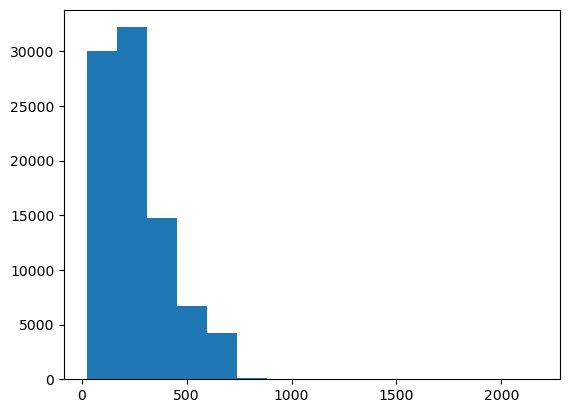

In [12]:
plt.hist(games_1['desc_tokens_length'], bins=15)

In [13]:
# Make list of sentence from description
games_1['sentences'] = games_1['description'].apply(string_to_sentences)
games_1['sentences']

0        [Galactic Bowling is an exaggerated and styliz...
1        [THE LAW!!, Looks to be a showdown atop a trai...
2        [Jolt Project: The army now has a new robotics...
3        [HENOSIS™ is a mysterious 2D Platform Puzzler ...
4        [ABOUT THE GAME Play as a hacker who has arran...
                               ...                        
97405    [., Femdom Game World - is a fascinating serie...
97406    [Enter the charming world of Blocky Farm where...
97407    [Mission brief: You are deployed to a heavily ...
97408    [Welcome to Escape The Garage, the thrilling e...
97409    [Scan Brain Lobes Organize &amp; clear dangero...
Name: sentences, Length: 87945, dtype: object

In [14]:
# get Lenghth of sentences
games_1['sentences_length'] = games_1['sentences'].apply(lambda x: len(x))
games_1['sentences_length'].describe()

count    87945.000000
mean        12.269782
std          7.824526
min          1.000000
25%          7.000000
50%         10.000000
75%         16.000000
max        437.000000
Name: sentences_length, dtype: float64

In [16]:
#get to similar games
g_1 = games_1[games_1["id"] == 849177]
g_2 = games_1[games_1["id"] == 391220]
#Get one not similar
g_3 = games_1[games_1["id"] == 1659180]
#Get embeddings
g_1['embeddings'] = [model.encode(g_1['sentences'].values[0]).mean(axis=0)]
g_2['embeddings'] = [model.encode(g_2['sentences'].values[0]).mean(axis=0)]
g_3['embeddings'] = [model.encode(g_3['sentences'].values[0]).mean(axis=0)]

/var/folders/3r/gx5x0f7n6lvd5yzgw2zddpv80000gn/T/ipykernel_32434/330415680.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_1['embeddings'] = [model.encode(g_1['sentences'].values[0]).mean(axis=0)]
/var/folders/3r/gx5x0f7n6lvd5yzgw2zddpv80000gn/T/ipykernel_32434/330415680.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_2['embeddings'] = [model.encode(g_2['sentences'].values[0]).mean(axis=0)]
/var/folders/3r/gx5x0f7n6lvd5yzgw2zddpv80000gn/T/ipykernel_32434/330415680.py:9: SettingWithCopyWarning: 


In [21]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
def get_sentence_embeddings(sentences, tokenizer, model):
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    
    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    sentence_embeddings = sentence_embeddings.mean(axis=0)
    return sentence_embeddings

/Users/aceto/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
g_1['embeddings'] = [get_sentence_embeddings(g_1['sentences'].values[0], tokenizer, model)]
g_2['embeddings'] = [get_sentence_embeddings(g_2['sentences'].values[0], tokenizer, model)]
g_3['embeddings'] = [get_sentence_embeddings(g_3['sentences'].values[0], tokenizer, model)]

/var/folders/3r/gx5x0f7n6lvd5yzgw2zddpv80000gn/T/ipykernel_23385/270590755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_1['embeddings'] = [get_sentence_embeddings(g_1['sentences'].values[0], tokenizer, model)]
/var/folders/3r/gx5x0f7n6lvd5yzgw2zddpv80000gn/T/ipykernel_23385/270590755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_2['embeddings'] = [get_sentence_embeddings(g_2['sentences'].values[0], tokenizer, model)]
/var/folders/3r/gx5x0f7n6lvd5yzgw2zddpv80000gn/T/ipykernel_23385/270590755

In [17]:
len(g_1['embeddings'].values[0])
model.similarity

<function sentence_transformers.util.cos_sim(a: 'list | np.ndarray | Tensor', b: 'list | np.ndarray | Tensor') -> 'Tensor'>

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
desc_sim_1_2 = cosine_similarity(g_1['embeddings'].values[0].reshape(1, -1), g_2['embeddings'].values[0].reshape(1, -1))
desc_sim_1_3 = cosine_similarity(g_1['embeddings'].values[0].reshape(1, -1), g_3['embeddings'].values[0].reshape(1, -1))
print(f"Similarity between {g_1['name'].values[0]} and {g_2['name'].values[0]}: {desc_sim_1_2[0][0]} -> should be high")
print(f"Similarity between {g_1['name'].values[0]} and {g_3['name'].values[0]}: {desc_sim_1_3[0][0]} -> should be low")

Similarity between Shadow of the Tomb Raider: Definitive Edition and Rise of the Tomb Raider™: 0.851446270942688 -> should be high
Similarity between Shadow of the Tomb Raider: Definitive Edition and TD Worlds: 0.5573999881744385 -> should be low


##### Old
Similarity between Shadow of the Tomb Raider: Definitive Edition and Rise of the Tomb Raider™: 0.8550347089767456 -> should be high
Similarity between Shadow of the Tomb Raider: Definitive Edition and TD Worlds: 0.3918170928955078 -> should be low

---

No pooling / pooling doesn't make a difference

Similarity between Shadow of the Tomb Raider: Definitive Edition and Rise of the Tomb Raider™: 0.8514463305473328 -> should be high
Similarity between Shadow of the Tomb Raider: Definitive Edition and TD Worlds: 0.557400107383728 -> should be low

In [ ]:
g_3['embeddings'].values[0]

## Experiment 2: Similarity based on description and genres (weighted approach)

In [26]:
games_2 = process_games_data(SOURCE)
games_2['sentences'] = games_1['description'].apply(string_to_sentences)

Description embedding same as before

In [27]:
g_1 = games_2[games_2["id"] == 849177]
g_2 = games_2[games_2["id"] == 391220]
#Get one not similar
g_3 = games_2[games_2["id"] == 1659180]
#Get embeddings
g_1['desc_embeddings'] = [get_sentence_embeddings(g_1['sentences'].values[0], tokenizer, model)]
g_2['desc_embeddings'] = [get_sentence_embeddings(g_2['sentences'].values[0], tokenizer, model)]
g_3['desc_embeddings'] = [get_sentence_embeddings(g_3['sentences'].values[0], tokenizer, model)]

/var/folders/3r/gx5x0f7n6lvd5yzgw2zddpv80000gn/T/ipykernel_23385/450569208.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_1['desc_embeddings'] = [get_sentence_embeddings(g_1['sentences'].values[0], tokenizer, model)]
/var/folders/3r/gx5x0f7n6lvd5yzgw2zddpv80000gn/T/ipykernel_23385/450569208.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_2['desc_embeddings'] = [get_sentence_embeddings(g_2['sentences'].values[0], tokenizer, model)]
/var/folders/3r/gx5x0f7n6lvd5yzgw2zddpv80000gn/T/ipykernel_23385

In [3]:
g_1['desc_embeddings']

NameError: name 'g_1' is not defined

Genres embedding
- Option one would be one hot encoding and just see how many genres are in common
- Option two would be to use bert (single word) and then average the embeddings, get similarity

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
g_1['genres'] = g_1['genres'].apply(lambda x: x.split(', '))
g_2['genres'] = g_2['genres'].apply(lambda x: x.split(', '))
g_3['genres'] = g_3['genres'].apply(lambda x: x.split(', '))
#genres = mlb.fit_transform(games_2['genres'])
#genres = pd.DataFrame(genres, columns=mlb.classes_)
#genres

In [28]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/Users/aceto/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
def get_genre_embeddings(genres: list):
    genre_embeddings = []
    for genre in genres:
        inputs = tokenizer(genre, return_tensors="pt")
        outputs = model(**inputs)
        genre_embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().numpy())
    return np.mean(genre_embeddings, axis=0)

In [30]:
g_1['genre_embeddings'] = [get_genre_embeddings(g_1['genres'].iloc[0])]
g_2['genre_embeddings'] = [get_genre_embeddings(g_2['genres'].iloc[0])]
g_3['genre_embeddings'] = [get_genre_embeddings(g_3['genres'].iloc[0])]
#Flatten the saved lists
g_1['genre_embeddings'] = g_1['genre_embeddings'].apply(lambda x: x.tolist()[0])
g_2['genre_embeddings'] = g_2['genre_embeddings'].apply(lambda x: x.tolist()[0])
g_3['genre_embeddings'] = g_3['genre_embeddings'].apply(lambda x: x.tolist()[0])

/var/folders/3r/gx5x0f7n6lvd5yzgw2zddpv80000gn/T/ipykernel_23385/287222231.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_1['genre_embeddings'] = [get_genre_embeddings(g_1['genres'].iloc[0])]
/var/folders/3r/gx5x0f7n6lvd5yzgw2zddpv80000gn/T/ipykernel_23385/287222231.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_2['genre_embeddings'] = [get_genre_embeddings(g_2['genres'].iloc[0])]
/var/folders/3r/gx5x0f7n6lvd5yzgw2zddpv80000gn/T/ipykernel_23385/287222231.py:3: SettingWithCopyWarning: 
A value 

In [90]:
g_1['genre_embeddings'].iloc[0]

[-0.0008037984371185303,
 -0.11213503777980804,
 0.0815303847193718,
 -0.0028296636883169413,
 -0.06435970962047577,
 -0.20625348389148712,
 0.3933359682559967,
 -0.23945556581020355,
 0.0820603221654892,
 -0.36178058385849,
 -0.25206729769706726,
 -0.1282980740070343,
 -0.010344203561544418,
 0.15746046602725983,
 0.022905871272087097,
 -0.10439974069595337,
 0.07984697073698044,
 0.21666286885738373,
 0.07688429951667786,
 0.14840039610862732,
 0.24641153216362,
 0.09543310105800629,
 0.21681277453899384,
 0.07824771851301193,
 0.2232428789138794,
 0.244905486702919,
 -0.31584393978118896,
 -0.03381050378084183,
 -0.06924383342266083,
 0.22415614128112793,
 0.08683694899082184,
 -0.26708853244781494,
 -0.352036714553833,
 0.3363131582736969,
 -0.22051116824150085,
 -0.19376087188720703,
 0.12614373862743378,
 -0.04823528230190277,
 -0.4103160798549652,
 -0.10704474151134491,
 -0.10445186495780945,
 -0.03122136741876602,
 -0.028791053220629692,
 -0.017617246136069298,
 0.0195629820227

In [91]:
g_1

,id,name,description,genres,sentences,desc_embeddings,genre_embeddings
7776,849177,Shadow of the Tomb Raider: Definitive Edition,In Shadow of the Tomb Raider Definitive Editio...,"Action,Adventure",[In Shadow of the Tomb Raider Definitive Editi...,"[tensor(-0.0054), tensor(-0.0033), tensor(-0.0...","[-0.0008037984371185303, -0.11213503777980804,..."


In [33]:
#Function to calculate similarity based on desc_embeddings and genre_embeddings
from sklearn.metrics.pairwise import cosine_similarity
def weighted_similarity(game_1: list, game_2:list, desc_weight=0.8):
    desc_emb_1 = np.array(game_1[0]).reshape(1, -1)
    desc_emb_2 = np.array(game_2[0]).reshape(1, -1)
    genre_emb_1 = np.array(game_1[1]).reshape(1, -1)
    genre_emb_2 = np.array(game_2[1]).reshape(1, -1)
    similarity_desc = cosine_similarity(desc_emb_1, desc_emb_2)
    similarity_genre = cosine_similarity(genre_emb_1, genre_emb_2)
    return desc_weight * similarity_desc + (1 - desc_weight) * similarity_genre

In [34]:
weighted_sim_1_2 = weighted_similarity(g_1[['desc_embeddings', 'genre_embeddings']].values[0].tolist(), g_2[['desc_embeddings', 'genre_embeddings']].values[0].tolist())
weighted_sim_1_3 = weighted_similarity(g_1[['desc_embeddings', 'genre_embeddings']].values[0].tolist(), g_3[['desc_embeddings', 'genre_embeddings']].values[0].tolist())

In [35]:
print(f"Similarity between {g_1['name'].values[0]} and {g_2['name'].values[0]}: {weighted_sim_1_2[0][0]} -> should be high")
print(f"Similarity between {g_1['name'].values[0]} and {g_3['name'].values[0]}: {weighted_sim_1_3[0][0]} -> should be low")
print(f"Genres of game 1 {g_1['genres'].values[0]}")
print(f"Genres of game 2 {g_2['genres'].values[0]}")
print(f"Genres of game 3 {g_3['genres'].values[0]}")

Similarity between Shadow of the Tomb Raider: Definitive Edition and Rise of the Tomb Raider™: 0.8811571121215823 -> should be high
Similarity between Shadow of the Tomb Raider: Definitive Edition and TD Worlds: 0.6451762764931596 -> should be low
Genres of game 1 Action,Adventure
Genres of game 2 Action,Adventure
Genres of game 3 Indie,Strategy


## Experiment 3: Similarity based on description and genres (concatenated approach)

In [36]:
games_3 = process_games_data(SOURCE)
games_3

,id,name,description,genres,sentences
0,20200,Galactic Bowling,Galactic Bowling is an exaggerated and stylize...,"Casual,Indie,Sports",[Galactic Bowling is an exaggerated and styliz...
1,655370,Train Bandit,THE LAW!! Looks to be a showdown atop a train....,"Action,Indie","[THE LAW!!, Looks to be a showdown atop a trai..."
2,1732930,Jolt Project,Jolt Project: The army now has a new robotics ...,"Action,Adventure,Indie,Strategy",[Jolt Project: The army now has a new robotics...
3,1355720,Henosis™,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"Adventure,Casual,Indie",[HENOSIS™ is a mysterious 2D Platform Puzzler ...
4,1139950,Two Weeks in Painland,ABOUT THE GAME Play as a hacker who has arrang...,"Adventure,Indie",[ABOUT THE GAME Play as a hacker who has arran...
...,...,...,...,...,...
97405,3080940,Femdom Game World: Mom,. Femdom Game World - is a fascinating series ...,Casual,"[., Femdom Game World - is a fascinating serie..."
97406,2593970,Blocky Farm,Enter the charming world of Blocky Farm where ...,"Casual,Simulation,Strategy",[Enter the charming world of Blocky Farm where...
97407,3137150,Infiltrate & Extract,Mission brief: You are deployed to a heavily g...,"Strategy,Free To Play",[Mission brief: You are deployed to a heavily ...
97408,3124670,Escape The Garage,"Welcome to Escape The Garage, the thrilling es...","Adventure,Casual,Indie","[Welcome to Escape The Garage, the thrilling e..."


In [ ]:
games_3['desc_genres'] = games_3['genres'] + '<SEP>.' games_3['description']

In [39]:
games_3['desc_genres_embeddings'] = games_3['desc_genres'].apply(string_to_sentences)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
games_3

In [38]:
#Embed desc_genres with sbert
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
g_1 = games_3[games_3["id"] == 849177]
g_2 = games_3[games_3["id"] == 391220]
g_3 = games_3[games_3["id"] == 1659180]
g_1['desc_genres_embeddings'] = [get_sentence_embeddings(g_1['desc_genres'].values[0], tokenizer, model)]
g_2['desc_genres_embeddings'] = [get_sentence_embeddings(g_2['desc_genres'].values[0], tokenizer, model)]
g_3['desc_genres_embeddings'] = [get_sentence_embeddings(g_3['desc_genres'].values[0], tokenizer, model)]
g_1

/Users/aceto/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


AttributeError: 'MPNetModel' object has no attribute 'encode'

In [26]:
desc_gen_sim_1_2 = model.similarity(g_1['desc_genres_embeddings'].values[0], g_2['desc_genres_embeddings'].values[0])
desc_gen_sim_1_3 = model.similarity(g_1['desc_genres_embeddings'].values[0], g_3['desc_genres_embeddings'].values[0])
print(f"Similarity between {g_1['name'].values[0]} and {g_2['name'].values[0]}: {desc_gen_sim_1_2[0][0]} -> should be high")
print(f"Similarity between {g_1['name'].values[0]} and {g_3['name'].values[0]}: {desc_gen_sim_1_3[0][0]} -> should be low")

Similarity between Shadow of the Tomb Raider: Definitive Edition and Rise of the Tomb Raider™: 0.8586603999137878 -> should be high
Similarity between Shadow of the Tomb Raider: Definitive Edition and TD Worlds: 0.35067635774612427 -> should be low


## Compare all three approaches

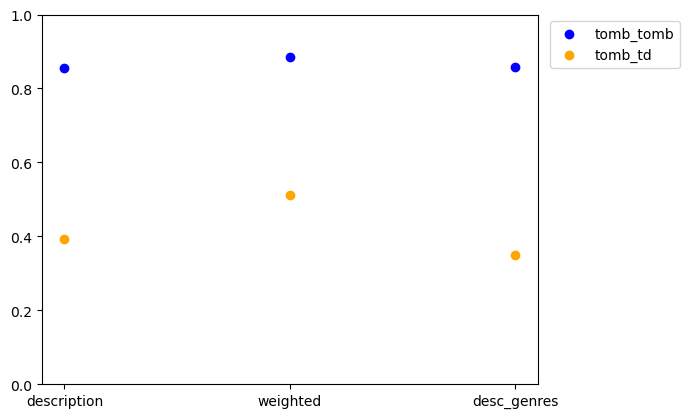

In [40]:
similarities = {
    'description': [desc_sim_1_2[0][0], desc_sim_1_3[0][0]],
    'weighted': [weighted_sim_1_2[0][0], weighted_sim_1_3[0][0]],
    'desc_genres': [desc_gen_sim_1_2[0][0], desc_gen_sim_1_3[0][0]]
}

fig, ax = plt.subplots()

for i, (name, values) in enumerate(similarities.items()):
    ax.scatter(i, values[0], color='blue', label='tomb_tomb' if i == 0 else "")
    ax.scatter(i, values[1], color='orange', label='tomb_td' if i == 0 else "")

# Set x-ticks and labels
ax.set_xticks(range(len(similarities)))
ax.set_xticklabels(similarities.keys())
ax.set_ylim(0, 1)
ax.legend(bbox_to_anchor=(1.01, 1))
plt.show()